In [7]:
from ase.io import read
import numpy as np
import os
from tqdm.auto import tqdm
from skcosmo.sample_selection import DirectionalConvexHull as GCH
import pickle
from skcosmo.preprocessing import KernelNormalizer
from skcosmo.preprocessing import StandardFlexibleScaler
from skcosmo.decomposition import PCovR
from rascal.representations import SphericalInvariants as SOAP
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge as KRR
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from dscribe.kernels.rematchkernel import REMatchKernel
from scipy.spatial.distance import cdist

def rmse(*x):
    return np.sqrt(mse(*x))

plt.rcParams['pdf.fonttype']=42

SMALL_FONT=10
MEDIUM_FONT=12
LARGE_FONT=16

# Load the frames and properties

In [8]:
frames = np.asarray(read('ice_w_props.xyz', ':'), dtype=object)
for frame in frames:
    frame.wrap(eps=1E-10)

energies = np.array([frame.info['energy [eV/H2O]'] for frame in frames])

indices = np.where(energies<-473.2)[0]

# Compute or Load the SOAP Representation

In [9]:
for frame in frames:
    mask = np.zeros(len(frame), dtype=bool)
    mask[np.where(frame.numbers==8)] = 1
    frame.arrays['center_atoms_mask'] = mask

In [24]:
hypers = {
    'interaction_cutoff': 5.0,
    'max_radial': 9,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'normalize': False
}
soap = SOAP(**hypers)
lens = [
    len(
        np.where(
            f.arrays.get('center_atoms_mask', np.ones(len(frame),
                                                             dtype=bool)))[0])
    for f in frames
]
splits = [sum(lens[:i]) for i in range(1, len(lens))]

if not os.path.exists('soaps.npy'):
    manager = soap.transform(frames)
    xa_raw = manager.get_features(soap)
    np.save('soaps.npy', xa_raw)
else:
    xa_raw = np.load('soaps.npy')
i_splits = np.array_split(np.arange(xa_raw.shape[0]), splits)

In [25]:
x_scaler = StandardFlexibleScaler(column_wise=False).fit(xa_raw)

In [26]:
X_raw = np.array([x.mean(axis=0) for x in np.array_split(xa_raw, splits)])
X = x_scaler.fit_transform(X_raw)
X.shape

(15869, 1701)

In [13]:
rematch = REMatchKernel(metric='gaussian', gamma=0.1)
if os.path.exists('rematch.npy'):
    K = np.load('rematch.npy')
else:
    K = np.zeros((len(frames), len(frames)))
pbar_i = tqdm(total=len(frames))
pbar_j = tqdm(total=len(frames))
pbar_ij = tqdm(total=len(frames)*len(frames))

  0%|          | 0/15869 [00:00<?, ?it/s]

  0%|          | 0/15869 [00:00<?, ?it/s]

  0%|          | 0/251825161 [00:00<?, ?it/s]

In [14]:
for i in range(len(frames)):
    if np.count_nonzero(K[i]) < K[i].shape[0]:
        xi = x_scaler.transform(xa_raw[i_splits[i]])
        pbar_j.reset(total=len(frames)-i)
        for j in range(i, len(frames)):
            if K[i,j]==0:
                xj = x_scaler.transform(xa_raw[i_splits[j]])
                K[i,j] = K[j,i] = rematch.get_global_similarity(cdist(xi, xj))
            pbar_ij.update(1)
            if i!=j:
                pbar_ij.update(1)
            pbar_j.update(1)
        if i % 100==0:
            np.save('rematch.npy', K)
            clear_output()
            plt.imshow(K)
            plt.show()
    else:
        pbar_ij.update(len(frames)-i)
        pbar_ij.update(len(frames)-i-1)
    pbar_i.update(1)
    
np.save('rematch.npy', K)

In [28]:
y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(energies.reshape(-1,1))
Kn = KernelNormalizer().fit_transform(K)

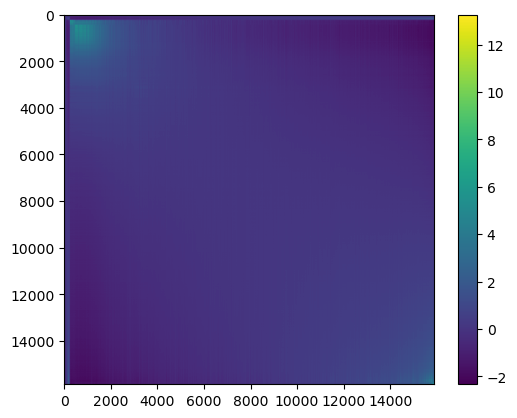

In [16]:
plt.imshow(Kn)
plt.colorbar()

## KPCA

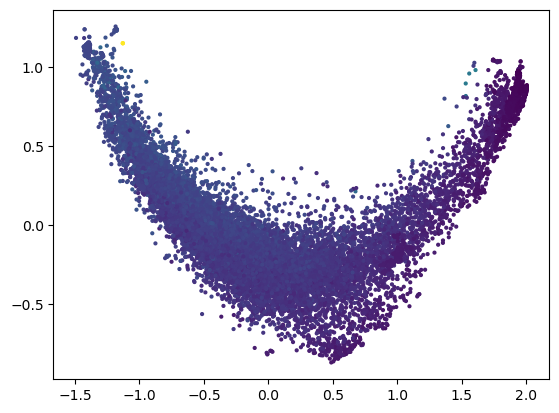

In [29]:
from sklearn.decomposition import KernelPCA

if not os.path.exists('kpca.sav'):
    kpca = KernelPCA(kernel='precomputed', n_components=2)
    kpca.fit(Kn)
    pickle.dump(kpca, open('kpca.sav', 'wb'))
else:
    kpca = pickle.load(open('kpca.sav', 'rb'))

t_kpca = kpca.transform(Kn)
plt.scatter(t_kpca[:, 0], t_kpca[:, 1], c=y, s=4)

## Create GCH Plot Using KPCA Features

In [31]:
gch=GCH()
gch.fit(t_kpca, y, dch_dims=[0,1])
chull = gch.selected_idx_

chull = chull[np.argsort(t_kpca[chull,0])]

<IPython.core.display.Javascript object>


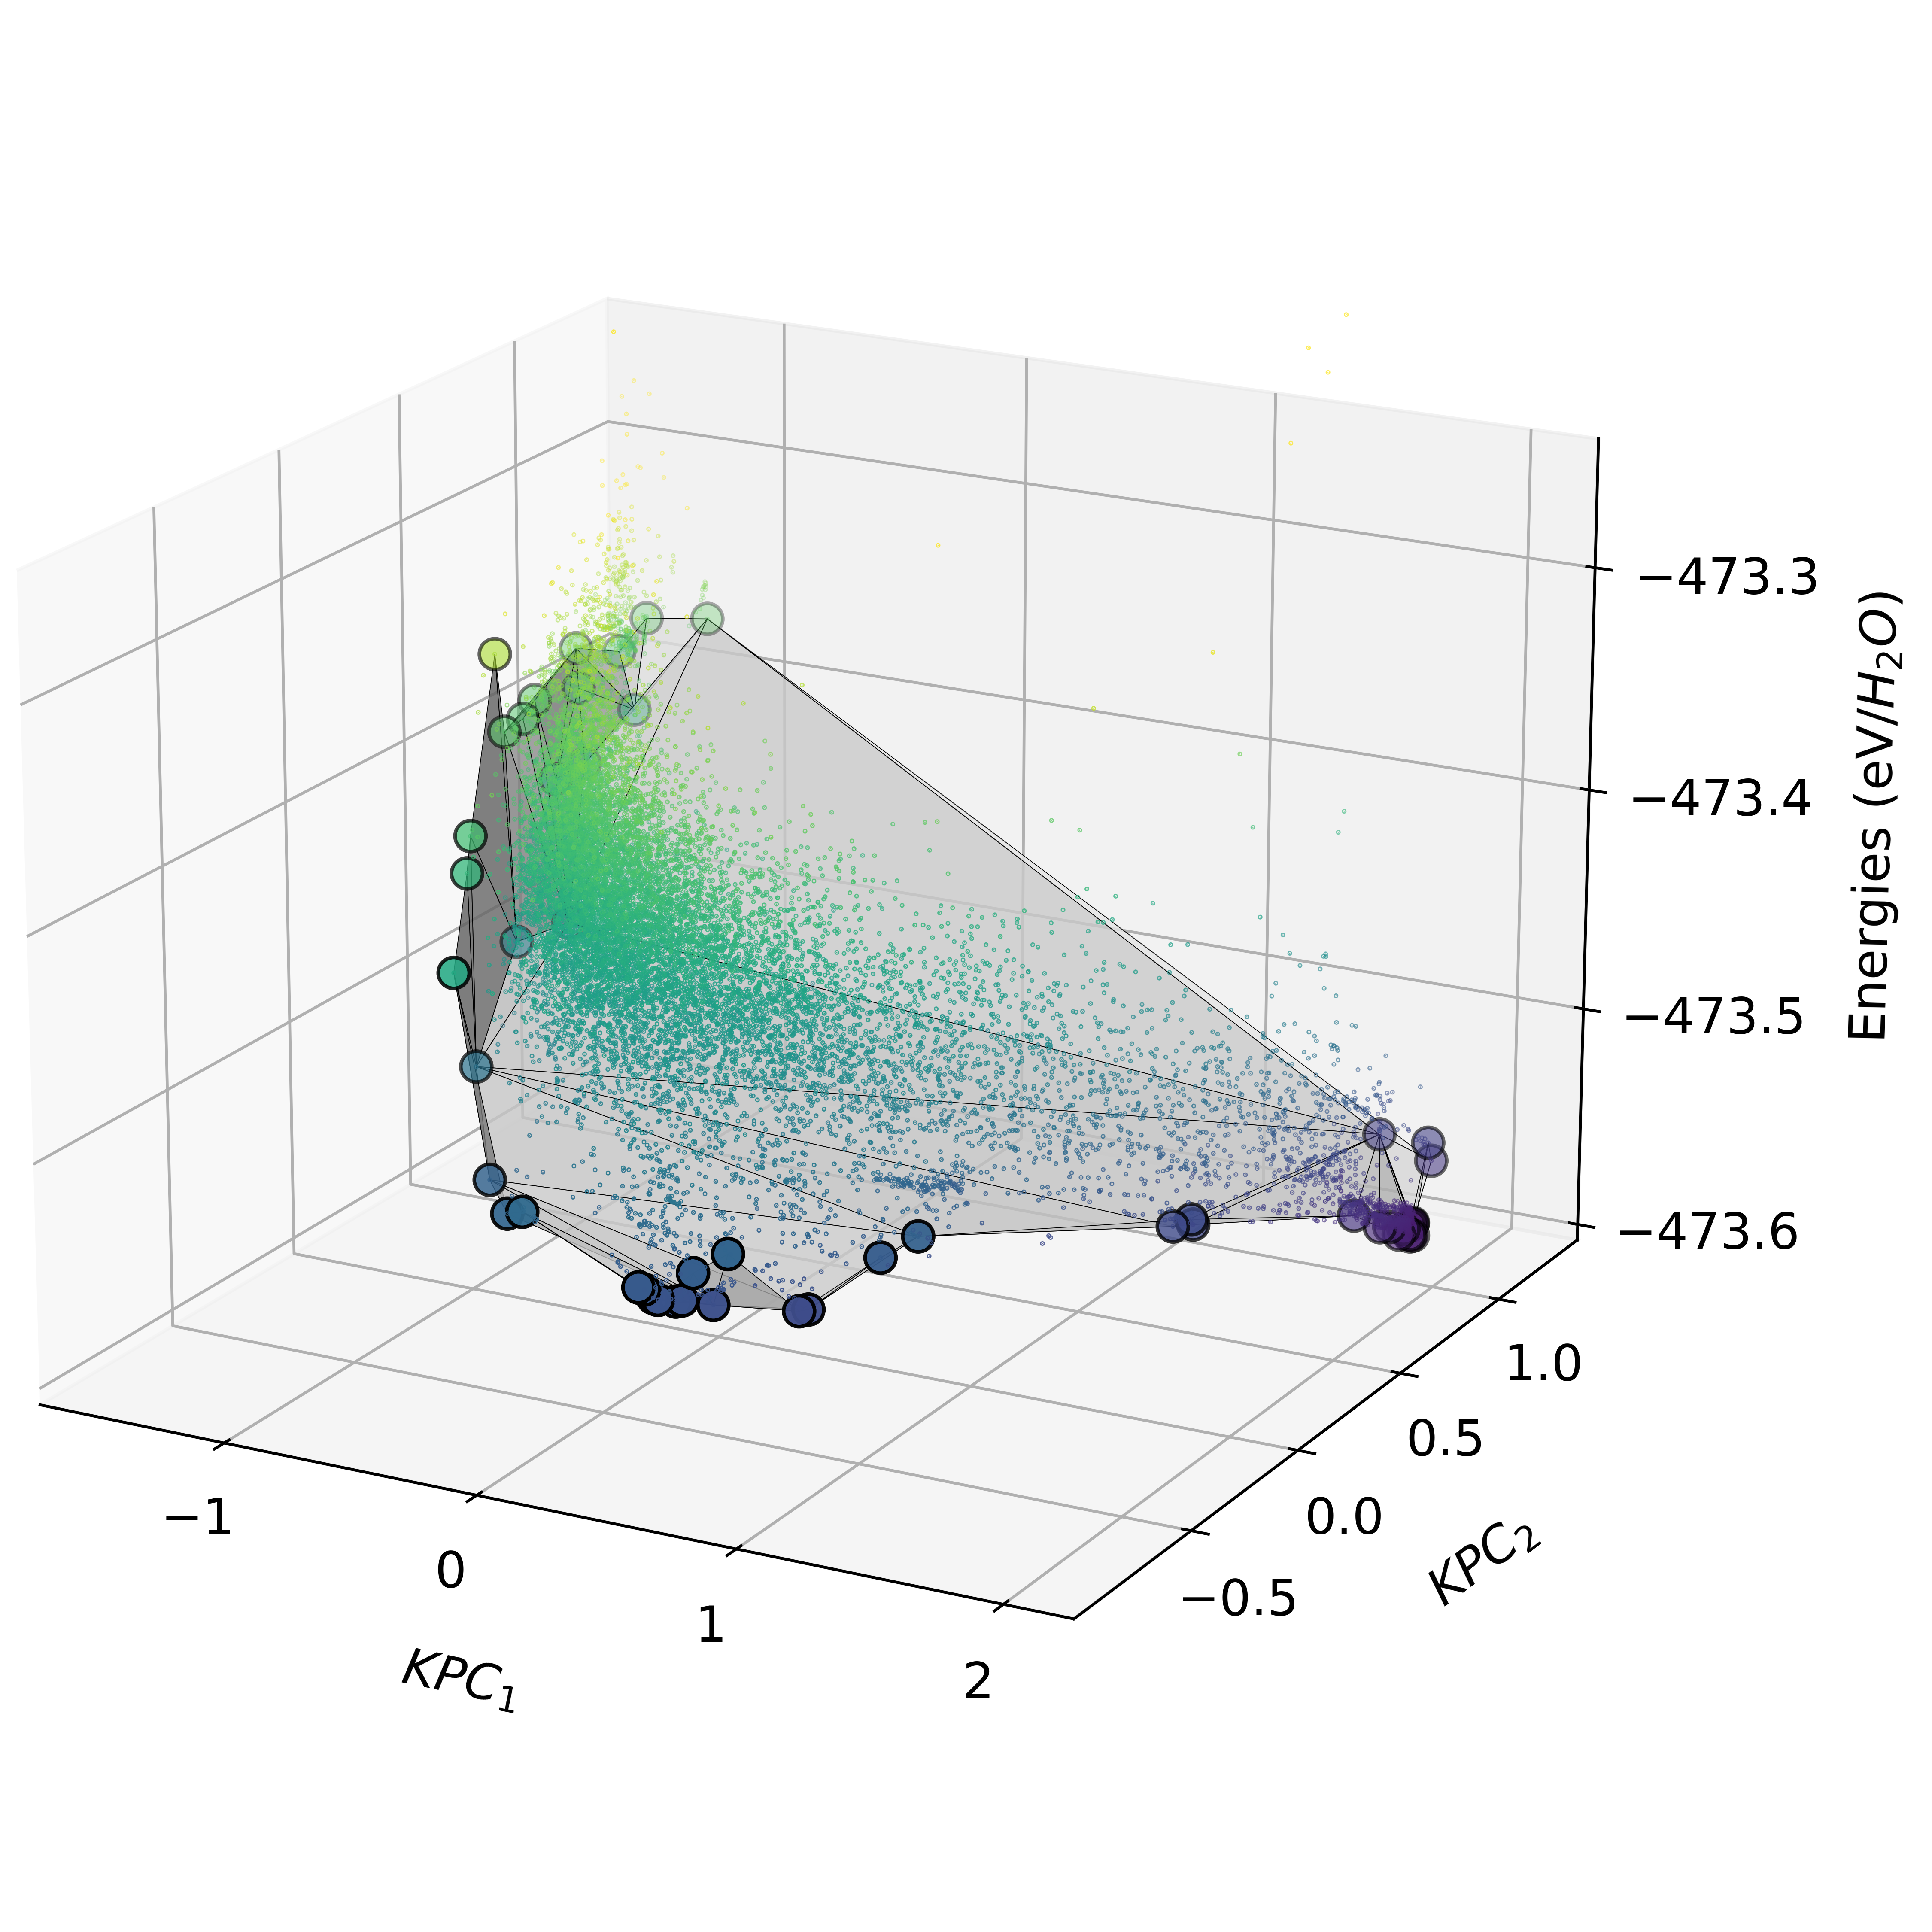

In [73]:
plt.rc('font', size=14)
%matplotlib notebook
hull_color = "white"
edge_color = "black"
point_color = "red"

from matplotlib import tri as mtri

fig = plt.figure(figsize=(7.5,7.5), dpi=300)
ax = fig.add_subplot(111, projection="3d")
ax.locator_params(nbins=6)
ax.locator_params(axis="y", nbins=6)
ax.locator_params(axis="z", nbins=4)
ax.tick_params(axis='z', which='major', pad=15)
ax.view_init(azim=-61.623376623376785, elev=18.63636363636363)
ax.plot_trisurf(
    t_kpca[chull, 0],
    t_kpca[chull, 1],
    y_scaler.inverse_transform(y).flatten()[chull],
    color=hull_color,
    edgecolor=edge_color,
    linewidth=0.2,
    alpha=0.8,
)
ax.scatter3D(
    t_kpca[:, 0],
    t_kpca[:, 1],
    y_scaler.inverse_transform(y),
    c=y_scaler.inverse_transform(y),
    # c=energies,
    # cmap="Greys",
    s=0.1,
    vmin=-473.6,
    vmax=-473.3,
    rasterized=True,
)
ax.scatter3D(
    t_kpca[chull, 0],
    t_kpca[chull, 1],
    y_scaler.inverse_transform(y).flatten()[chull],
    c=y_scaler.inverse_transform(y)[chull].flatten(),
    s=300,
    ec="k",
    # fc='none',
    vmin=-473.6,
    vmax=-473.3,
    marker=".",
)
ax.set_xlabel("$KPC_1$", labelpad=15)
ax.set_ylabel("$KPC_2$", labelpad=15)
ax.set_zlabel("Energies (eV/$H_2O$)", labelpad=30)

ax.set_zlim([-473.6, -473.25])

plt.subplots_adjust(left=-0.17, right=1.0, top=0.975, bottom=0.05)
plt.savefig('DCH.png')
plt.savefig('DCH.pdf')